In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp

import matplotlib.pyplot as plt
import seaborn as sns

from dnn_model1 import DnnWithEmbeddingLayers
from dnn_model2 import SimpleDnn
from tuning import GridSearch

## Contents
1. <a href="#section_1">Import Data</a>
2. <a href="#section_2">Grid Search Hyperparameter Tuning</a>
3. <a href="#section_3">Compare Tuning Results to Find the Best</a>
4. <a href="#section_4">Comparing dnn_model1 and dnn_model2 Without Imbalanced Data Solutions</a>
5. <a href="#section_5">Compare Imbalanced Data Solutions</a>
6. <a href="#section_6">Visualize Effect of Using Initial Bias</a>

In [2]:
root_dir = os.getcwd()

<a id="section_1"></a>
#### Import Data
This section is to import training and testing data for dnn_model1 and dnn_model2.<br>
As we use two approachs to deal with imbalanced data problem, we will import four different datasets.<br>
Datasets:<br>
1. Dataset for dnn_model1 without oversampling.
We will set the initial bias and class weights to solve imbalanced data problem.<br>
2. Dataset for dnn_model2 without oversampling.
We will set the initial bias and class weights to solve imbalanced data problem.<br>
3. Oversampling dataset for dnn_model1.<br>
4. Oversampling dataset for dnn_model2.<br>

(Setting initial bias is optional.
Setting initial bias will allow the model speed up the learning instead of using the first few epochs to learn the imbalanced data bias.
However, initial bias does not affect much of the performance. <a href="#section_6">Please see: Visualize Effect of Using Initial Bias</a>)

In [4]:
def import_datasets(root_dir, file_dir_lists):
    """
    Import input and target datasets.

    file_dir_lists: a nested list.
                    The first inner list is file directories of train and test inputs.
                    The second inner list is file directories of train and test targets.
    """
    import_datasets = []
    for idx in range(2):
        input_dataset = np.loadtxt(f"{root_dir}\\{file_dir_lists[0][idx]}", delimiter=",")
        # Shape of target_dataset is (example_nums, ).
        target_dataset = np.loadtxt(f"{root_dir}\\{file_dir_lists[1][idx]}", delimiter=",")
        # Reshape target_dataset to (example_nums, 1)
        target_dataset = target_dataset.reshape(target_dataset.shape[0], 1)
        import_datasets.append((input_dataset, target_dataset))

    # import_datasets is a nested lists.
    # The first inner list is a tuple of train input and target datasets.
    # The second inner list is a tuple of test input and target datasets.
    return import_datasets

Setting class weights during training can allow the model to pay more attention to the minority class.<br>
For more details, please check TensorFlow tutorials: [Classification on imbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights).

In [5]:
# Dataset for dnn_model1 without oversampling.
# Set initial bias and class weights.
model1_datasets_filedir = [["model1_data\\x_train.txt", "model1_data\\x_test.txt"],
                            ["model1_data\\y_train.txt", "model1_data\\y_test.txt"]]
model1_datasets = import_datasets(root_dir=root_dir,
                                                file_dir_lists=model1_datasets_filedir)
model1_x_train, model1_y_train = model1_datasets[0]
model1_x_test, model1_y_test = model1_datasets[1]
print(f"x_train shape: {model1_x_train.shape}\ny_train shape: {model1_y_train.shape}")
print(f"x_test shape: {model1_x_test.shape}\ny_test shape: {model1_y_test.shape}")

# dnn_model1 output bias
# np.bincount only accept 1-d array and int type.
model1_neg, model1_pos = np.bincount(model1_y_train.reshape(model1_y_train.shape[0],).astype(int))
model1_total = model1_neg + model1_pos
model1_initial_bias = np.log([model1_pos/model1_neg])
print(model1_initial_bias)

# dnn_model1 class weights
model1_weight_for_0 = (1 / model1_neg) * (model1_total / 2.0)
model1_weight_for_1 = (1 / model1_pos) * (model1_total / 2.0)

model1_classweight = {0: model1_weight_for_0, 1: model1_weight_for_1}
print(f"label 0: {model1_weight_for_0}")
print(f"label 1: {model1_weight_for_1}")

x_train shape: (15326, 46)
y_train shape: (15326, 1)
x_test shape: (3832, 46)
y_test shape: (3832, 1)
[-1.10087552]
label 0: 0.6662898878358404
label 1: 2.0033986928104577


In [5]:
# Dataset for dnn_model2.
# Set initial bias and class weights.
model2_datasets_filedir = [["model2_data\\x_train.txt", "model2_data\\x_test.txt"],
                            ["model2_data\\y_train.txt", "model2_data\\y_test.txt"]]
model2_datasets = import_datasets(root_dir=root_dir,
                                                file_dir_lists=model2_datasets_filedir)
model2_x_train, model2_y_train = model2_datasets[0]
model2_x_test, model2_y_test = model2_datasets[1]
print(f"x_train shape: {model2_x_train.shape}\ny_train shape: {model2_y_train.shape}")
print(f"x_test shape: {model2_x_test.shape}\ny_test shape: {model2_y_test.shape}")

# dnn_model2 output bias
# np.bincount only accept 1-d array and int type.
model2_neg, model2_pos = np.bincount(model2_y_train.reshape(model2_y_train.shape[0],).astype(int))
model2_total = model2_neg + model2_pos
model2_initial_bias = np.log([model2_pos/model2_neg])
print(model2_initial_bias)

# dnn_model1 class weights
model2_weight_for_0 = (1 / model2_neg) * (model2_total / 2.0)
model2_weight_for_1 = (1 / model2_pos) * (model2_total / 2.0)

model2_classweight = {0: model2_weight_for_0, 1: model2_weight_for_1}
print(f"label 0: {model2_weight_for_0}")
print(f"label 1: {model2_weight_for_1}")

x_train shape: (15326, 46)
y_train shape: (15326, 1)
x_test shape: (3832, 46)
y_test shape: (3832, 1)
[-1.10087552]
label 0: 0.6662898878358404
label 1: 2.0033986928104577


In [17]:
# Import over-resampling dataset for dnn_model1.
resample_model1_datasets_filedir = [["SMOTE_model1_data\\x_train.txt", "SMOTE_model1_data\\x_test.txt"],
                            ["SMOTE_model1_data\\y_train.txt", "SMOTE_model1_data\\y_test.txt"]]
resample_model1_datasets = import_datasets(root_dir=root_dir,
                                file_dir_lists=resample_model1_datasets_filedir)
resample_model1_x_train, resample_model1_y_train = resample_model1_datasets[0]
resample_model1_x_test, resample_model1_y_test = resample_model1_datasets[1]
print(f"x_train shape: {resample_model1_x_train.shape}\ny_train shape: {resample_model1_y_train.shape}")
print(f"x_test shape: {resample_model1_x_test.shape}\ny_test shape: {resample_model1_y_test.shape}")

x_train shape: (23002, 46)
y_train shape: (23002, 1)
x_test shape: (3832, 46)
y_test shape: (3832, 1)


In [4]:
# Import over-resampling dataset for dnn_model2.
resample_model2_datasets_filedir = [["SMOTE_model2_data\\x_train.txt", "SMOTE_model2_data\\x_test.txt"],
                            ["SMOTE_model2_data\\y_train.txt", "SMOTE_model2_data\\y_test.txt"]]
resample_model2_datasets = import_datasets(root_dir=root_dir,
                                file_dir_lists=resample_model2_datasets_filedir)
resample_model2_x_train, resample_model2_y_train = resample_model2_datasets[0]
resample_model2_x_test, resample_model2_y_test = resample_model2_datasets[1]
print(f"x_train shape: {resample_model2_x_train.shape}\ny_train shape: {resample_model2_y_train.shape}")
print(f"x_test shape: {resample_model2_x_test.shape}\ny_test shape: {resample_model2_y_test.shape}")

x_train shape: (23002, 46)
y_train shape: (23002, 1)
x_test shape: (3832, 46)
y_test shape: (3832, 1)


<a id="section_2"></a>
#### Grid Search Hyperparameter Tuning
In order to obtain the best result among different models and dataset,
we use TensorBoard plugin tools to tune hyperparameters.<br>
For more details about tuning hyperparameters using TensorBoard.<br>
Please check TensorBoard guide:[Hyperparameter Tuning with the HParams Dashboard](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams)

The tuning class is tune optimizers, regularizers and regularizer lambda rates.<br>
Please note that the tuning class only tunes one regularizer on each run along with a list of different
optimizers and lambda rates.

In [19]:
# Set attributes of tuning class. Can also be used for section_.
# Change attributes depending on what model and what imbalanced data solutions to use.
model_x_train = resample_model1_x_train
model_y_train = resample_model1_y_train
model_x_test = resample_model1_x_test
model_y_test = resample_model1_y_test
model_layers_neurons_list = [64, 32, 8, 1]
model_embedding_col_nums = 2
model_embedding_cols_dataset_indexes = [[44, 45], [45, 46]] # Set to None if it is for dnn_model2.
model_embedding_cols_output_dims = [32, 11] # Set to None if it is for dnn_model2.
model_output_bias = None # Set to None if using SMOTE training datasets.
model_classweight = None # Set to None if using SMOTE training datasets.
model_regularizer_rate = 0.05
model_regularizer="l2" # Change depending on if l1 or l2 regularizer.
model_metrics = [ 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')
]

In [7]:
# Set attributes of tuning class.
# Change run_dir for every model, regularizer and imbalanced data solutions run.
run_dir = "test_second_model1_l1_logs/hparam_tuning/"
metricsname_list = ["accuracy", "precision", "recall", "auc", "prc"]
optimizer_list=["adam", "rmsprop", "sgd"]
tuning_model_name = "model1" # Change depending on which model is used.
regularizer_lambdarates = [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5]
epochs = 100 # Change if it is for testing few epochs.

In [9]:
# dnn_model1 for setting class weights and resampled.
tf.random.set_seed(10) # For reproducible.
tuning_generator = GridSearch(
    run_dir, metricsname_list, tuning_model_name, model_x_train, model_y_train,
    model_x_test, model_y_test, model_metrics, epochs, model_layers_neurons_list,
    model_embedding_col_nums, model_embedding_cols_dataset_indexes, model_embedding_cols_output_dims,
    model_output_bias, model_classweight, model_regularizer
) # Set initial_bias=None, classweight=None if dataset is resampled.
tuning_generator.create_hparams(optimizer_list, regularizer_lambdarates)
tuning_generator.start_run()

--- Starting trial: run-0
{'l2 regularizer': 0.001, 'optimizer': 'adam'}
Epoch 1/10
479/479 [==============================] - 5s 4ms/step - loss: 0.8857 - accuracy: 0.7494 - precision: 0.4985 - recall: 0.6667 - auc: 0.7629 - prc: 0.5085
Epoch 2/10
479/479 [==============================] - 2s 4ms/step - loss: 0.5991 - accuracy: 0.7708 - precision: 0.5289 - recall: 0.7459 - auc: 0.7970 - prc: 0.5444
Epoch 3/10
479/479 [==============================] - 2s 4ms/step - loss: 0.5808 - accuracy: 0.7746 - precision: 0.5343 - recall: 0.7542 - auc: 0.8003 - prc: 0.5472
Epoch 4/10
479/479 [==============================] - 2s 4ms/step - loss: 0.5733 - accuracy: 0.7768 - precision: 0.5379 - recall: 0.7522 - auc: 0.8012 - prc: 0.5509
Epoch 5/10
479/479 [==============================] - 2s 4ms/step - loss: 0.5698 - accuracy: 0.7752 - precision: 0.5352 - recall: 0.7535 - auc: 0.8017 - prc: 0.5482
Epoch 6/10
479/479 [==============================] - 2s 4ms/step - loss: 0.5653 - accuracy: 0.7742 - 

'Done'

In [ ]:
# dnn_model2 for setting class weights and resampled.
tf.random.set_seed(12) # For reproducible.
tuning_generator = GridSearch(
    run_dir, metricsname_list, tuning_model_name, model_x_train, model_y_train,
    model_x_test, model_y_test, model_metrics, epochs, model_layers_neurons_list,
    model_embedding_col_nums, model_embedding_cols_dataset_indexes, model_embedding_cols_output_dims,
    model_output_bias, model_classweight, model_regularizer
) # Set initial_bias=None, classweight=None if dataset is resampled.
tuning_generator.create_hparams(optimizer_list, regularizer_lambdarates)
tuning_generator.start_run()

In [10]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Visualizing tuning results on TensorBoard. 
%tensorboard --logdir test2_second_model1_l1_logs/hparam_tuning/

<a id="section_3"></a>
#### Compare Tuning Results to Find the Best

In [6]:
testds_file_names_list = ["model1_l1", "model1_l2", "model2_l1", "model2_l2",
                        "model1_resample_l1", "model1_resample_l2", 
                        "model2_resample_l1", "model2_resample_l2"]

In [7]:
def bulk_import_testds_result(files_rootdir, filenames_list):
    """
    Import all model tuning result csv files as dataframes.

    files_rootdir: the directory of folder where all tuning result csv files live.
    filenames_list: a list of csv files' names.
    """
    result_list = []
    for file_idx in range(len(filenames_list)):
        testds_result_df = pd.read_csv(f"{files_rootdir}//{filenames_list[file_idx]}")
        testds_result_df["var_name"] = \
            testds_result_df["optimizer"].apply(lambda x: f"{filenames_list[file_idx]}_{x}")
        result_list.append(testds_result_df)

    return result_list # A list of tuning result dataframe.

def concat_testds_results(result_list):
    """
    Combine all imported tuning result dataframes.

    result_list: a list of tuning result dataframe 
                that are generated from function bulk_import_testds_result().
    """
    concat_df = result_list[0]
    for result_idx in range(1, len(result_list)):
        concat_df = pd.concat([concat_df, result_list[result_idx]], axis=0)

    return concat_df

In [5]:
testds_files_rootdir = "tuning_csv_result_files_rootdir"
testds_results_list = bulk_import_testds_result(testds_files_rootdir, testds_file_names_list)
comb_results_df = concat_testds_results(testds_results_list)

In [6]:
comb_results_df.head(5)

,l1 regularizer,optimizer,accuracy,auc,prc,precision,recall,var_name,l2 regularizer
0,0.100,rmsprop,0.774269,0.793037,0.525259,0.533030,0.737395,model1_l1_rmsprop,NaN
1,0.005,rmsprop,0.774791,0.792464,0.523409,0.533738,0.739496,model1_l1_rmsprop,NaN
2,0.050,sgd,0.722077,0.782648,0.501786,0.464353,0.773109,model1_l1_sgd,NaN
3,0.003,adam,0.775835,0.794969,0.522831,0.535201,0.742647,model1_l1_adam,NaN
4,0.050,adam,0.773225,0.795496,0.525259,0.531040,0.745798,model1_l1_adam,NaN


In [7]:
def find_highest_values(df, value_list):
    """
    find the best tuning result of its relating metric in value_list from the dataframe.

    df: it is the combine tuning result from function concat_testds_results().
    value_list: a list of metrics, such as, ["accuracy", "precision", "recall", "auc", "prc"].
    """
    highest_value_list = []
    for value_idx in range(len(value_list)):
        value_name = value_list[value_idx]
        highest_value_df = df.loc[df[value_name]==df[value_name].max()]
        highest_value_list.append(highest_value_df)

    return highest_value_list

In [9]:
testds_highest_values = find_highest_values(
    comb_results_df,
    ["accuracy", "precision", "recall", "auc", "prc"]
)
print(f"Highest Accuracy:\n{testds_highest_values[0]}")
print("------------------------------")
print(f"Highest Precision:\n{testds_highest_values[1]}")
print("------------------------------")
print(f"Highest Recall:\n{testds_highest_values[2]}")
print("------------------------------")
print(f"Highest AUC:\n{testds_highest_values[3]}")
print("------------------------------")
print(f"Highest PRC:\n{testds_highest_values[4]}")

highest accuracy:
    l1 regularizer optimizer  accuracy       auc       prc  precision  \
1              NaN       sgd  0.784969  0.797070  0.534747   0.551447   
11             NaN       sgd  0.784969  0.797508  0.534531   0.551364   

      recall                var_name  l2 regularizer  
1   0.720588  model1_resample_l2_sgd            0.01  
11  0.721639  model1_resample_l2_sgd            0.50  
highest precision:
   l1 regularizer optimizer  accuracy      auc       prc  precision    recall  \
1             NaN       sgd  0.784969  0.79707  0.534747   0.551447  0.720588   

                 var_name  l2 regularizer  
1  model1_resample_l2_sgd            0.01  
highest recall:
    l1 regularizer optimizer  accuracy       auc       prc  precision  \
2             0.05       sgd  0.693372  0.787442  0.506630   0.437605   
21            0.01       sgd  0.693372  0.787347  0.506364   0.437605   
23            0.03       sgd  0.693372  0.787420  0.506608   0.437605   
26            0.10 

Visualize Prediction Results on Confusion Matrix
with Optimal Hyperparameters, Models and Imbalanced Data Solutions:<br>
1. Highest recall: model2_resample_l1_sgd 0.05
2. Highest AUC and PRC: model1_l2_sgd 0.05 (setting classweights for solving imbalanced data)
3. Highest accuracy and precision: model1_resample_l2_sgd 0.01<br>

Setting models' attributes, <a href="#section_3">please go to</a>.

In [7]:
# pred_result source
# https://www.kaggle.com/datasets/arashnic/job-change-dataset-answer
pred_ds = np.loadtxt(os.path.join(root_dir, "preprocessed_pred.csv"), delimiter=",")
pred_result = np.load(os.path.join(root_dir, "test_target_ds.npy"))

In [ ]:
model1_generator = DnnWithEmbeddingLayers()
model1_pred = model1_generator.deep_neural_network(
    model_x_train, model_embedding_col_nums, model_embedding_cols_dataset_indexes,
    model_embedding_cols_output_dims, model_layers_neurons_list, output_bias=model_output_bias,
    regularizer_lambda=model_regularizer_rate, regularizer=model_regularizer
)
model1_pred.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=model_metrics)
model1_pred.fit(model_x_train, model_y_train, 
                epochs=100, class_weight=model_classweight)

test_evaluation = model1_pred.evaluate(model_x_test, model_y_test)
pred_evaluation = model1_pred.evaluate(pred_ds, pred_result)

In [ ]:
model2_generator = SimpleDnn()
model2_pred = model2_generator.deep_neural_network(
    model_x_train, model_layers_neurons_list, output_bias=model_output_bias,
    regularizer_lambda=model_regularizer_rate, regularizer=model_regularizer
)
model2_pred.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=model_metrics)
model2_pred.fit(model_x_train, model_y_train, 
                epochs=100, class_weight=model_classweight)

model2_test_evaluation = model2_pred.evaluate(model_x_test, model_y_test)
model2_pred_evaluation = model2_pred.evaluate(pred_ds, pred_result)

In [10]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Not Leaving (True Negatives): ', cm[0][0])
  print('Not Leaving Incorrectly Detected (False Positives): ', cm[0][1])
  print('Change Jobs Incorrectly Detected (False Negatives): ', cm[1][0])
  print('Change Jobs Detected (True Positives): ', cm[1][1])
  print('Total Change Jobs: ', np.sum(cm[1]))

loss :  0.7650686502456665
accuracy :  0.27054956555366516
precision :  0.27054956555366516
recall :  1.0
auc :  0.5
prc :  0.27054956555366516

Not Leaving (True Negatives):  0
Not Leaving Incorrectly Detected (False Positives):  1553
Change Jobs Incorrectly Detected (False Negatives):  0
Change Jobs Detected (True Positives):  576
Total Change Jobs:  576


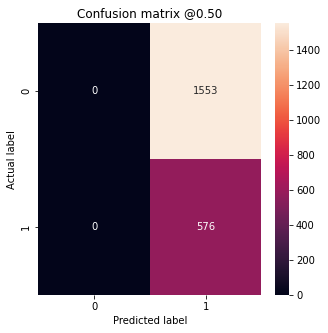

In [10]:
# Highest recall: model2_resample_l1_sgd 0.05
model2_predictions_baseline = model2_pred.predict(pred_ds)

for name, value in zip(model2_pred.metrics_names, model2_pred_evaluation):
  print(name, ': ', value)
print()

plot_cm(pred_result, model2_predictions_baseline)

loss :  0.5888217091560364
accuracy :  0.7510568499565125
precision :  0.5388513803482056
recall :  0.5538194179534912
auc :  0.7690272331237793
prc :  0.5392464399337769

Not Leaving (True Negatives):  1280
Not Leaving Incorrectly Detected (False Positives):  273
Change Jobs Incorrectly Detected (False Negatives):  257
Change Jobs Detected (True Positives):  319
Total Change Jobs:  576


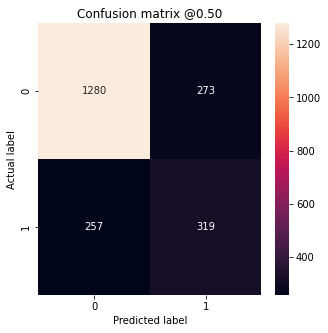

In [13]:
# Highest auc and prc-model1_l2_sgd 0.05
model1_predictions_baseline = model1_pred.predict(pred_ds)

for name, value in zip(model1_pred.metrics_names, pred_evaluation):
  print(name, ': ', value)
print()

plot_cm(pred_result, model1_predictions_baseline)

loss :  0.5633509159088135
accuracy :  0.7510568499565125
precision :  0.5502183437347412
recall :  0.4375
auc :  0.7400478720664978
prc :  0.5181198120117188

Not Leaving (True Negatives):  1347
Not Leaving Incorrectly Detected (False Positives):  206
Change Jobs Incorrectly Detected (False Negatives):  324
Change Jobs Detected (True Positives):  252
Total Change Jobs:  576


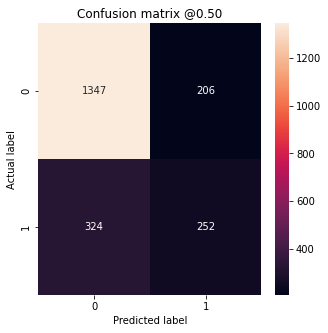

In [10]:
# Highest accuracy and precision - model1_resample_l2_sgd 0.01
model1_predictions_baseline = model1_pred.predict(pred_ds)

for name, value in zip(model1_pred.metrics_names, pred_evaluation):
  print(name, ': ', value)
print()

plot_cm(pred_result, model1_predictions_baseline)

<a id="section_4"></a>
#### Comparing dnn_model1 and dnn_model2 Without Imbalanced Data Solutions
1. Without regularization
2. With Regularization<br>
Setting model attributes, please go to

In [ ]:
model1_generator = DnnWithEmbeddingLayers()
model1_pred = model1_generator.deep_neural_network(
    model_x_train, model_embedding_col_nums, model_embedding_cols_dataset_indexes,
    model_embedding_cols_output_dims, model_layers_neurons_list, output_bias=model_output_bias,
    regularizer_lambda=model_regularizer_rate, regularizer=model_regularizer
) # output_bias needs to be None.
model1_pred.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=model_metrics)
model1_pred.fit(model_x_train, model_x_train, 
                epochs=100, validation_split=0.2) # Do not set class weight here.
model1_history = model1_pred.history.history

In [ ]:
model2_generator = SimpleDnn()
model2_pred = model2_generator.deep_neural_network(
    model_x_train, model_layers_neurons_list, output_bias=model_output_bias,
    regularizer_lambda=model_regularizer_rate, regularizer=model_regularizer
) # output_bias needs to be None.
model2_pred.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=model_metrics)
model2_pred.fit(model2_x_train, model2_y_train, 
                epochs=100, validation_split=0.2) # Do not set class weight here.
model2_hisotry = model2_pred.history.history

In [8]:
def history_compare_df(history_list, epochs, comapre_titles, history_metrics_list):
    """
    Generate a dataframe that contains different models' history results.

    Args:
    history_list: a list of history results, which each history result is a dictionary.
    epochs: it is the epochs of model training.
    compare_titles: a list of history result titles.
    history_metrics_list: a list of metrics that you wish to show in the plot.   
    """
    compare_dict = {"epochs": [epoch for epoch in range(epochs)]}
    for compare_idx in range(len(history_list)):
        history = history_list[compare_idx]
        history_title = comapre_titles[compare_idx]
        for metircs in history_metrics_list:
            compare_dict[f"{history_title}_{metircs}"] = history[metircs]

    compare_df = pd.DataFrame(compare_dict)
    melt_compare_df = pd.melt(compare_df, id_vars="epochs", var_name="loss")

    return melt_compare_df

<AxesSubplot:xlabel='epochs', ylabel='value'>

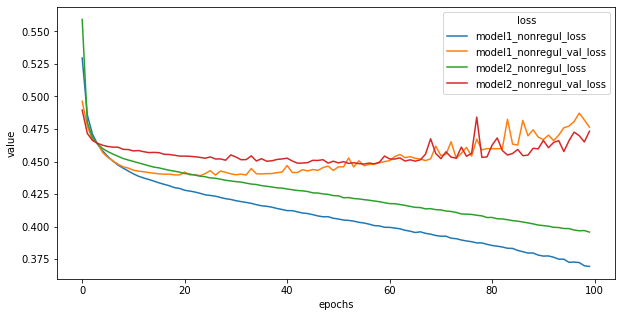

In [23]:
# Without regularizers
model1_model2_nonregul = [model1_history, model2_hisotry]
nonregul_titles = ["model1_nonregul", "model2_nonregul"]
nonregul_metrics = ["loss", "val_loss"]
compare_nonregul = history_compare_df(
    model1_model2_nonregul, 100, nonregul_titles, nonregul_metrics
)
nonregul_fig, nonregul_ax = plt.subplots(1, 1, figsize=[10, 5])

sns.lineplot(x="epochs", y="value", hue="loss", data=compare_nonregul,
            ax=nonregul_ax)

<AxesSubplot:xlabel='epochs', ylabel='value'>

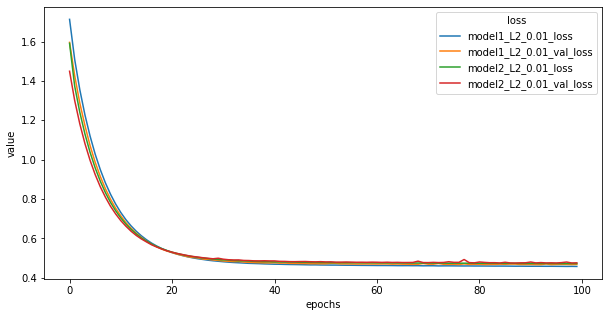

In [14]:
# With regularizer L2 lambda rate 0.01. Optimizer is SGD.
model1_model2_regul = [model1_history, model2_hisotry]
regul_titles = ["model1_L2_0.01", "model2_L2_0.01"]
regul_metrics = ["loss", "val_loss"]
compare_regul = history_compare_df(
    model1_model2_regul, 100, regul_titles, regul_metrics
)
regul_fig, regul_ax = plt.subplots(1, 1, figsize=[10, 5])

sns.lineplot(x="epochs", y="value", hue="loss", data=compare_regul,
            ax=regul_ax)

<a id="section_5"></a>
#### Compare Imbalanced Data Solutions
Setting model attributes, <a href="#section_3">please go to</a>

In [18]:
# dnn_model1 with setting class weights.
# Optimizer: SGD. Regularizer: l2 with lambda rate 0.05.
model1_generator = DnnWithEmbeddingLayers()
model1_pred = model1_generator.deep_neural_network(
    model_x_train, model_embedding_col_nums, model_embedding_cols_dataset_indexes,
    model_embedding_cols_output_dims, model_layers_neurons_list, output_bias=model_output_bias,
    regularizer_lambda=model_regularizer_rate, regularizer=model_regularizer
)
model1_pred.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=model_metrics)
model1_pred.fit(model_x_train, model_y_train, 
                epochs=100, validation_split=0.2, class_weight=model_classweight)
model1_history = model1_pred.history.history

Epoch 1/100
384/384 [==============================] - 3s 5ms/step - loss: 5.1680 - accuracy: 0.7554 - precision: 0.5596 - recall: 0.0755 - auc: 0.5488 - prc: 0.3385 - val_loss: 3.6091 - val_accuracy: 0.7694 - val_precision: 0.5545 - val_recall: 0.4582 - val_auc: 0.7510 - val_prc: 0.4853
Epoch 2/100
384/384 [==============================] - 1s 4ms/step - loss: 2.7417 - accuracy: 0.7479 - precision: 0.4934 - recall: 0.5308 - auc: 0.7542 - prc: 0.4850 - val_loss: 2.0512 - val_accuracy: 0.7244 - val_precision: 0.4690 - val_recall: 0.6628 - val_auc: 0.7696 - val_prc: 0.5270
Epoch 3/100
384/384 [==============================] - 1s 4ms/step - loss: 1.6380 - accuracy: 0.7257 - precision: 0.4620 - recall: 0.6280 - auc: 0.7623 - prc: 0.4936 - val_loss: 1.3068 - val_accuracy: 0.7459 - val_precision: 0.4990 - val_recall: 0.6255 - val_auc: 0.7735 - val_prc: 0.5335
Epoch 4/100
384/384 [==============================] - 1s 4ms/step - loss: 1.1261 - accuracy: 0.7251 - precision: 0.4608 - recall: 0.

In [20]:
# dnn_model1 with resampled data. Optimizer: SGD.
# Regularizer: l2 with lambda rate 0.05.
resample_model1_generator = DnnWithEmbeddingLayers()
resample_model1_pred = resample_model1_generator.deep_neural_network(
    model_x_train, model_embedding_col_nums, model_embedding_cols_dataset_indexes,
    model_embedding_cols_output_dims, model_layers_neurons_list, output_bias=model_output_bias,
    regularizer_lambda=model_regularizer_rate, regularizer=model_regularizer
)
resample_model1_pred.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=model_metrics)
resample_model1_pred.fit(model_x_train, model_y_train, 
                epochs=100, validation_split=0.2, class_weight=model_classweight)
resample_model1_history = resample_model1_pred.history.history

Epoch 1/100
576/576 [==============================] - 3s 4ms/step - loss: 4.4193 - accuracy: 0.6250 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7223 - prc: 0.5837 - val_loss: 2.9882 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 1.0000
Epoch 2/100
576/576 [==============================] - 2s 4ms/step - loss: 1.8406 - accuracy: 0.6250 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7688 - prc: 0.6397 - val_loss: 1.5962 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 1.0000
Epoch 3/100
576/576 [==============================] - 2s 4ms/step - loss: 1.0300 - accuracy: 0.6314 - precision: 0.7053 - recall: 0.0291 - auc: 0.7707 - prc: 0.6386 - val_loss: 1.1310 - val_accuracy: 0.1978 - val_precision: 1.0000 - val_recall: 0.1978 - val_auc: 0.0000e+00 - val_prc: 1.0000
Epoch 4/100
576/576 [==============================] - 2s 4ms/step - loss: 0.7713

<AxesSubplot:xlabel='epochs', ylabel='value'>

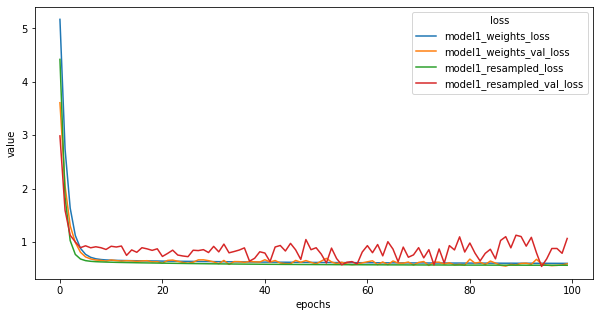

In [21]:
# model1_history is the result from model1 setting class weights in the 
imbalancedata_solutions = [model1_history, resample_model1_history]
imbalancedata_solutions_titles = ["model1_weights", "model1_resampled"]
imbalancedata_solutions_metrics = ["loss", "val_loss"]
compare_imbalancedata_solutions = history_compare_df(
    imbalancedata_solutions, 100, imbalancedata_solutions_titles, imbalancedata_solutions_metrics
)
solut_fig, solut_ax = plt.subplots(1, 1, figsize=[10, 5])

sns.lineplot(x="epochs", y="value", hue="loss", data=compare_imbalancedata_solutions,
            ax=solut_ax)

<a id="section_6"></a>
#### Visualize Effect of Using Initial Bias
Setting model attributes, <a href="#section_3">please go to</a>

In [ ]:
# dnn_model1 with class weights only.
# Optimizer: SGD. Regularizer: l2 with lambda rate 0.05
nobias_model1_generator = DnnWithEmbeddingLayers()
nobias_model1_pred = nobias_model1_generator.deep_neural_network(
    model_x_train, model_embedding_col_nums, model_embedding_cols_dataset_indexes,
    model_embedding_cols_output_dims, model_layers_neurons_list, output_bias=model_output_bias,
    regularizer_lambda=model_regularizer_rate, regularizer=model_regularizer
)
nobias_model1_pred.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=model_metrics)
nobias_model1_pred.fit(model_x_train, model_y_train, 
                epochs=100, validation_split=0.2, class_weight=model_classweight)
nobias_model1_history = nobias_model1_pred.history.history

<AxesSubplot:xlabel='epochs', ylabel='value'>

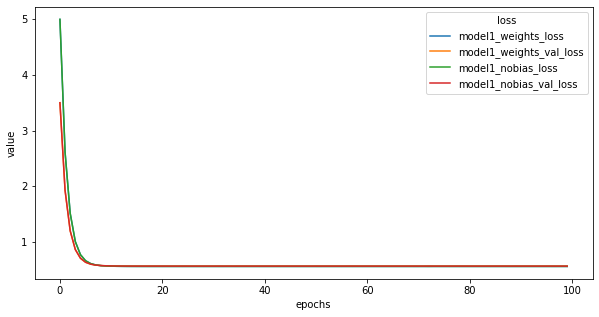

In [14]:
# model1_history is the history of results from
# model1 setting class weights only in the section "Compare Imbalanced Data Solutions"
compare_bias = [model1_history, nobias_model1_history]
compare_bias_titles = ["model1_weights", "model1_nobias"]
compare_bias_metrics = ["loss", "val_loss"]
compare_bias_df = history_compare_df(
    compare_bias, 100, compare_bias_titles, compare_bias_metrics
)
bias_fig, bias_ax = plt.subplots(1, 1, figsize=[10, 5])

sns.lineplot(x="epochs", y="value", hue="loss", data=compare_bias_df,
            ax=bias_ax)